# Recession Model: XGBoost

In [1]:
#Standard libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pandas import read_csv
import time
sns.set(style='whitegrid', palette='muted')
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 10, 6

from sklearn import metrics
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split

from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import SGDRegressor
from sklearn.linear_model import SGDClassifier

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
from xgboost import XGBClassifier
from sklearn.decomposition import PCA

In [2]:
# Imports data
macro = pd.read_csv('US_FRED_data_1970_2020.csv', header=0, index_col=0, parse_dates=True)
macro.shape

(612, 125)

In [3]:
macro

,RPI,W875RX1,DPCERA3M086SBEA,CMRMTSPLx,RETAILx,INDPRO,IPFPNSS,IPFINAL,IPCONGD,IPDCONGD,...,DNDGRG3M086SBEA,DSERRG3M086SBEA,CES0600000008,CES2000000008,CES3000000008,MZMSL,DTCOLNVHFNM,DTCTHFNM,INVEST,VXOCLSx
sasdate,,,,,,,,,,,,,,,,,,,,,
1970-01-01,4080.053,3761.7,27.765,422711.205,31569.05660,38.1217,39.9113,38.4242,51.0376,33.4227,...,22.200,15.478,3.40,4.54,3.16,469.0,9293.00,27612.00,110.6784,16.2759
1970-02-01,4090.141,3768.4,27.887,423086.917,31716.32840,38.0966,40.0186,38.6228,51.5414,33.9101,...,22.297,15.547,3.43,4.56,3.17,462.8,9207.00,27508.00,109.0177,17.6779
1970-03-01,4105.972,3782.6,27.745,418143.008,31419.71056,38.0472,39.9972,38.5200,51.4797,34.2322,...,22.292,15.619,3.45,4.60,3.19,460.2,9144.00,27330.00,110.4947,17.4539
1970-04-01,4146.769,3760.3,27.766,416029.630,31792.03854,37.9493,40.0107,38.5102,51.6882,34.2164,...,22.443,15.697,3.47,4.66,3.19,458.1,9187.00,27361.00,112.4359,18.3914
1970-05-01,4122.950,3768.2,27.957,420548.324,32246.29942,37.9051,40.0228,38.5309,51.9687,34.2502,...,22.491,15.765,3.48,4.64,3.22,457.3,9197.00,27348.00,112.2189,37.6526
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-08-01,17509.277,13822.2,115.806,1515433.000,538646.00000,95.8924,95.7804,97.1051,99.3591,103.8453,...,98.675,120.600,25.51,29.39,22.87,21074.4,344023.25,726723.85,4372.9468,20.2777
2020-09-01,17608.769,13959.5,117.336,1524622.000,549528.00000,95.6019,95.2329,96.1270,97.8903,102.4553,...,98.508,120.964,25.49,29.09,23.01,21249.9,347627.43,730734.42,4440.5811,28.3241
2020-10-01,17560.994,14153.1,117.817,1539562.000,550038.00000,96.6454,96.2605,96.7673,98.1616,103.3618,...,98.398,121.094,25.58,29.40,22.99,21369.3,348262.68,730398.69,4519.5569,30.9408


In [4]:
# Imports data
tran_code = pd.read_csv('US_FRED_data_transform_code.csv', header=0, index_col=0, parse_dates=False)
tran_code.shape

(1, 125)

In [5]:
tran_code

,RPI,W875RX1,DPCERA3M086SBEA,CMRMTSPLx,RETAILx,INDPRO,IPFPNSS,IPFINAL,IPCONGD,IPDCONGD,...,DNDGRG3M086SBEA,DSERRG3M086SBEA,CES0600000008,CES2000000008,CES3000000008,MZMSL,DTCOLNVHFNM,DTCTHFNM,INVEST,VXOCLSx
Symbol,,,,,,,,,,,,,,,,,,,,,
Tran_code,5,5,5,5,5,5,5,5,5,5,...,6,6,6,6,6,6,6,6,6,1


In [6]:
def data_transform(x, tran_code):
    
    if tran_code == 1:
        x_tr = x        
        
    elif tran_code == 2:
        x_tr = x.diff()
            
    elif tran_code == 3:
        x_tr = x.diff().diff()
        
    elif tran_code == 4:
        x_tr = np.log(x)
        
    elif tran_code == 5:
        x_tr = np.log(x).diff()*100
    
    elif tran_code == 6:
        x_tr = np.log(x).diff().diff()*100
    
    else:
        x_tr = (x.pct_change()-1)*100
    
    return x_tr    

In [7]:
macro_tr=[]

for col in macro.columns:
    tr_code = tran_code[col].values
    data_tr = data_transform(macro[col], tr_code)
    macro_tr.append(data_tr)

macro_tr = pd.DataFrame(macro_tr).T

In [8]:
macro_tr

,RPI,W875RX1,DPCERA3M086SBEA,CMRMTSPLx,RETAILx,INDPRO,IPFPNSS,IPFINAL,IPCONGD,IPDCONGD,...,DNDGRG3M086SBEA,DSERRG3M086SBEA,CES0600000008,CES2000000008,CES3000000008,MZMSL,DTCOLNVHFNM,DTCTHFNM,INVEST,VXOCLSx
sasdate,,,,,,,,,,,,,,,,,,,,,
1970-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16.2759
1970-02-01,0.246947,0.177953,0.438440,0.088842,0.465422,-0.065863,0.268485,0.515531,0.982275,1.447760,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,17.6779
1970-03-01,0.386306,0.376110,-0.510499,-1.175414,-0.939622,-0.129755,-0.053489,-0.266519,-0.119781,0.945382,...,-0.458412,0.017239,-0.297086,0.433807,0.312977,0.767396,0.243123,-0.271828,2.857575,17.4539
1970-04-01,0.988698,-0.591286,0.075661,-0.506701,1.178048,-0.257644,0.033747,-0.025445,0.404196,-0.046166,...,0.697516,0.036106,-0.003361,0.422546,-0.628933,0.106014,1.155765,0.762551,0.395842,18.3914
1970-05-01,-0.576055,0.209869,0.685536,1.080291,1.418739,-0.116539,0.030237,0.053738,0.541210,0.098734,...,-0.461442,-0.065881,-0.290266,-1.726023,0.936044,0.282581,-0.360361,-0.160888,-1.934758,37.6526
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-08-01,-3.279001,1.042881,0.683643,0.212971,0.811046,1.052210,1.303505,1.257238,0.746547,-0.975054,...,-0.041113,0.016066,-0.275567,0.340820,-0.836629,-0.245214,-0.567483,-0.265594,-1.578047,20.2777
2020-09-01,0.566616,0.988428,1.312524,0.604530,2.000114,-0.303404,-0.573260,-1.012366,-1.489310,-1.347569,...,-0.370246,0.057291,-0.196102,-1.332697,0.479027,0.672130,-0.146940,0.220884,-0.139709,28.3241
2020-10-01,-0.271682,1.377340,0.409096,0.975145,0.092764,1.085592,1.073259,0.663889,0.276764,0.880885,...,0.057657,-0.193957,0.430889,2.086021,-0.697246,-0.269003,-0.859634,-0.596307,0.228057,30.9408


In [9]:
# Imports data
gdp = pd.read_csv('US_recession_1970_2020.csv', header=0, index_col=0, parse_dates=True)
gdp.shape

(612, 1)

In [10]:
gdp

,USRECM
observation_date,
1970-01-01,1
1970-02-01,1
1970-03-01,1
1970-04-01,1
1970-05-01,1
...,...
2020-08-01,0
2020-09-01,0
2020-10-01,0


In [11]:
macro_final = pd.concat([macro_tr, gdp], axis=1)
macro_final

,RPI,W875RX1,DPCERA3M086SBEA,CMRMTSPLx,RETAILx,INDPRO,IPFPNSS,IPFINAL,IPCONGD,IPDCONGD,...,DSERRG3M086SBEA,CES0600000008,CES2000000008,CES3000000008,MZMSL,DTCOLNVHFNM,DTCTHFNM,INVEST,VXOCLSx,USRECM
1970-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16.2759,1
1970-02-01,0.246947,0.177953,0.438440,0.088842,0.465422,-0.065863,0.268485,0.515531,0.982275,1.447760,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,17.6779,1
1970-03-01,0.386306,0.376110,-0.510499,-1.175414,-0.939622,-0.129755,-0.053489,-0.266519,-0.119781,0.945382,...,0.017239,-0.297086,0.433807,0.312977,0.767396,0.243123,-0.271828,2.857575,17.4539,1
1970-04-01,0.988698,-0.591286,0.075661,-0.506701,1.178048,-0.257644,0.033747,-0.025445,0.404196,-0.046166,...,0.036106,-0.003361,0.422546,-0.628933,0.106014,1.155765,0.762551,0.395842,18.3914,1
1970-05-01,-0.576055,0.209869,0.685536,1.080291,1.418739,-0.116539,0.030237,0.053738,0.541210,0.098734,...,-0.065881,-0.290266,-1.726023,0.936044,0.282581,-0.360361,-0.160888,-1.934758,37.6526,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-08-01,-3.279001,1.042881,0.683643,0.212971,0.811046,1.052210,1.303505,1.257238,0.746547,-0.975054,...,0.016066,-0.275567,0.340820,-0.836629,-0.245214,-0.567483,-0.265594,-1.578047,20.2777,0
2020-09-01,0.566616,0.988428,1.312524,0.604530,2.000114,-0.303404,-0.573260,-1.012366,-1.489310,-1.347569,...,0.057291,-0.196102,-1.332697,0.479027,0.672130,-0.146940,0.220884,-0.139709,28.3241,0
2020-10-01,-0.271682,1.377340,0.409096,0.975145,0.092764,1.085592,1.073259,0.663889,0.276764,0.880885,...,-0.193957,0.430889,2.086021,-0.697246,-0.269003,-0.859634,-0.596307,0.228057,30.9408,0
2020-11-01,-1.005914,-0.263894,-0.555791,-0.184964,-1.364630,0.531976,0.367595,0.453463,0.149132,1.474346,...,-0.095026,0.076644,-0.551113,0.564284,0.351319,0.533688,0.414667,0.682979,24.8047,0


In [12]:
# Show rows and columns
print("Rows, Columns:");print(macro_final.shape);print("\n")

# Describe DataFrame columns
print("Columns:");print(macro_final.columns);print("\n")

# Show info on DataFrame
print("Info:");print(macro_final.info(max_cols=1000)); print("\n")

# Count Non-NA values
print("Non-NA:");print(macro_final.count()); print("\n")

# Show head
print("Head");print(macro_final.head()); print("\n")

# Show tail
print("Tail");print(macro_final.tail());print("\n")

# Show summary statistics
print("Summary statistics:");print(macro_final.describe());print("\n")

Rows, Columns:
(612, 126)


Columns:
Index(['RPI', 'W875RX1', 'DPCERA3M086SBEA', 'CMRMTSPLx', 'RETAILx', 'INDPRO',
       'IPFPNSS', 'IPFINAL', 'IPCONGD', 'IPDCONGD',
       ...
       'DSERRG3M086SBEA', 'CES0600000008', 'CES2000000008', 'CES3000000008',
       'MZMSL', 'DTCOLNVHFNM', 'DTCTHFNM', 'INVEST', 'VXOCLSx', 'USRECM'],
      dtype='object', length=126)


Info:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 612 entries, 1970-01-01 to 2020-12-01
Data columns (total 126 columns):
 #    Column           Non-Null Count  Dtype  
---   ------           --------------  -----  
 0    RPI              611 non-null    float64
 1    W875RX1          611 non-null    float64
 2    DPCERA3M086SBEA  611 non-null    float64
 3    CMRMTSPLx        611 non-null    float64
 4    RETAILx          611 non-null    float64
 5    INDPRO           611 non-null    float64
 6    IPFPNSS          611 non-null    float64
 7    IPFINAL          611 non-null    float64
 8    IPCONGD          611 non-nu

              RPI     W875RX1  DPCERA3M086SBEA   CMRMTSPLx     RETAILx  \
count  611.000000  611.000000       611.000000  611.000000  611.000000   
mean     0.237676    0.216482         0.234135    0.210597    0.463487   
std      0.796574    0.661749         0.875659    1.157477    1.557811   
min     -5.073132   -6.056840       -12.980466  -12.239323  -15.891806   
25%      0.036570   -0.011455         0.005087   -0.303080   -0.092002   
50%      0.256728    0.273029         0.246840    0.196538    0.468253   
75%      0.454588    0.474898         0.514158    0.790937    1.072548   
max     12.286154    4.012112         8.115276    7.686217   16.697863   

           INDPRO     IPFPNSS     IPFINAL     IPCONGD    IPDCONGD  ...  \
count  611.000000  611.000000  611.000000  611.000000  611.000000  ...   
mean     0.155007    0.146971    0.154450    0.110750    0.187814  ...   
std      0.994354    1.028040    1.126996    1.063389    3.275335  ...   
min    -14.609953  -15.345295  -16.33

In [13]:
#Define Data for Machine Learning

X_start = 2  # 1970-M3
X_lag = 1

# Features and Target
X, y = macro_final.iloc[X_start:,:-1].shift(X_lag).dropna(), macro_final.iloc[X_start+X_lag:,125]


In [14]:
X

,RPI,W875RX1,DPCERA3M086SBEA,CMRMTSPLx,RETAILx,INDPRO,IPFPNSS,IPFINAL,IPCONGD,IPDCONGD,...,DNDGRG3M086SBEA,DSERRG3M086SBEA,CES0600000008,CES2000000008,CES3000000008,MZMSL,DTCOLNVHFNM,DTCTHFNM,INVEST,VXOCLSx
1970-04-01,0.386306,0.376110,-0.510499,-1.175414,-0.939622,-0.129755,-0.053489,-0.266519,-0.119781,0.945382,...,-0.458412,0.017239,-0.297086,0.433807,0.312977,0.767396,0.243123,-0.271828,2.857575,17.4539
1970-05-01,0.988698,-0.591286,0.075661,-0.506701,1.178048,-0.257644,0.033747,-0.025445,0.404196,-0.046166,...,0.697516,0.036106,-0.003361,0.422546,-0.628933,0.106014,1.155765,0.762551,0.395842,18.3914
1970-06-01,-0.576055,0.209869,0.685536,1.080291,1.418739,-0.116539,0.030237,0.053738,0.541210,0.098734,...,-0.461442,-0.065881,-0.290266,-1.726023,0.936044,0.282581,-0.360361,-0.160888,-1.934758,37.6526
1970-07-01,0.311838,0.323239,0.335667,0.399715,0.634801,-0.323964,-0.234641,-0.213303,0.250222,1.921268,...,-0.124762,-0.014493,0.570604,1.714922,-0.316847,0.327742,0.465830,0.758026,0.429053,23.7760
1970-08-01,0.559793,0.527650,-0.021392,0.106662,0.833842,0.245315,0.087117,-0.106692,0.239641,0.178562,...,0.243732,-0.014320,-0.290191,-0.016298,-0.311030,0.174020,-3.447940,-1.827710,0.935810,21.3723
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-08-01,0.598813,0.991831,1.432611,2.601717,1.439484,4.006429,4.254453,4.738868,4.180368,15.062340,...,-0.747237,-0.031421,0.432630,-1.166406,1.584905,-0.705023,-0.621750,0.056104,-0.287128,24.3785
2020-09-01,-3.279001,1.042881,0.683643,0.212971,0.811046,1.052210,1.303505,1.257238,0.746547,-0.975054,...,-0.041113,0.016066,-0.275567,0.340820,-0.836629,-0.245214,-0.567483,-0.265594,-1.578047,20.2777
2020-10-01,0.566616,0.988428,1.312524,0.604530,2.000114,-0.303404,-0.573260,-1.012366,-1.489310,-1.347569,...,-0.370246,0.057291,-0.196102,-1.332697,0.479027,0.672130,-0.146940,0.220884,-0.139709,28.3241
2020-11-01,-0.271682,1.377340,0.409096,0.975145,0.092764,1.085592,1.073259,0.663889,0.276764,0.880885,...,0.057657,-0.193957,0.430889,2.086021,-0.697246,-0.269003,-0.859634,-0.596307,0.228057,30.9408


In [15]:
y

1970-04-01    1
1970-05-01    1
1970-06-01    1
1970-07-01    1
1970-08-01    1
             ..
2020-08-01    0
2020-09-01    0
2020-10-01    0
2020-11-01    0
2020-12-01    0
Name: USRECM, Length: 609, dtype: int64

# Principal Component Analysis (PCA)

In [16]:
steps_X = [('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)),
           ('pca', PCA(n_components = 1, random_state=1))]

pl_pca_X = Pipeline(steps_X)

X_pca_model = pl_pca_X.fit(X)

print('n_components:', 1, '  ', 'variance explained:', '%.3f' %X_pca_model.steps[1][1].explained_variance_ratio_.sum())

X_pca = X_pca_model.transform(X)

n_components: 1    variance explained: 0.208


In [17]:
for n_comp in [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,30,50,125]:

    steps_X = [('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)),
               ('pca', PCA(n_components = n_comp, random_state=1))]
    
    pl_pca_X = Pipeline(steps_X)
    X_pca_model = pl_pca_X.fit(X)
    
    print('n_components:', n_comp, '  ', 'variance explained:', '%.3f' %X_pca_model.steps[1][1].explained_variance_ratio_.sum())


n_components: 1    variance explained: 0.208
n_components: 2    variance explained: 0.287
n_components: 3    variance explained: 0.359
n_components: 4    variance explained: 0.415
n_components: 5    variance explained: 0.470
n_components: 6    variance explained: 0.505
n_components: 7    variance explained: 0.534
n_components: 8    variance explained: 0.558
n_components: 9    variance explained: 0.580
n_components: 10    variance explained: 0.600
n_components: 11    variance explained: 0.618
n_components: 12    variance explained: 0.635
n_components: 13    variance explained: 0.651
n_components: 14    variance explained: 0.666
n_components: 15    variance explained: 0.680
n_components: 16    variance explained: 0.694
n_components: 17    variance explained: 0.707
n_components: 18    variance explained: 0.719
n_components: 19    variance explained: 0.731
n_components: 20    variance explained: 0.742
n_components: 30    variance explained: 0.829
n_components: 50    variance explained: 0.9

In [18]:
n_train = 453   # 2007-M12
n_records = len(X)
n_forecast = n_records-n_train

j = 0
for i in range(n_train, n_records):    
    #train, test = X[0:i], X[i:i+1]   #expanding window
    train, test = X[j:i], X[i:i+1]   #rolling window
#    print('train=%d, test=%d' % (len(train), len(test)))
    j += 1

# Grid Search for Optimal Hyperparameters

In [19]:
# pipeline
def pipeline(config):

    # unpack config
    n_trees, n_comps, learn_rate, reg_alp, reg_lamb = config

    # Steps
    steps = [('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)),
             ('pca', PCA(n_components=n_comps, random_state=1)),
             ('xgboost', XGBClassifier(objective='binary:logistic', n_estimators=n_trees, learning_rate=learn_rate, reg_alpha=reg_alp, reg_lambda=reg_lamb, eval_metric='logloss', use_label_encoder=False, random_state=1))
            ]

    pipeline = Pipeline(steps)

    return pipeline

In [20]:
def walk_forward_validation(cfg):
    
    n_train = 453

    n_records = len(X)

    y_test_list = []

    y_pred_list = []

    y_prob_list = []

    j = 0

    for i in range(n_train, n_records):
    
        X_train, X_test, y_train, y_test = X[j:i], X[i:i+1], y[j:i], y[i:i+1]
       
        model = pipeline(cfg).fit(X_train, y_train)        
    
        y_pred = model.predict(X_test)
   
        y_prob = model.predict_proba(X_test)[:, 1]

        y_pred_list.extend(y_pred)
    
        y_prob_list.extend(y_prob)
    
        y_test_list.extend(y_test)
    
        j += 1

    score_acc = metrics.accuracy_score(y_test_list, y_pred_list)
    
    print(' > %.3f' % score_acc)
    
    return score_acc 

In [21]:
# score a model, return None on failure
def repeat_evaluate(config, n_repeats=1):
    # convert config to a key
    key = str(config)
    # fit and evaluate the model n times
    scores = [walk_forward_validation(config) for _ in range(n_repeats)]
    # summarize score
    result = np.mean(scores)
    print('> Model[%s] %.3f' % (key, result))
    return (key, result)

In [22]:
# grid search configs
def grid_search(cfg_list):
    # evaluate configs
    scores = [repeat_evaluate(cfg) for cfg in cfg_list]
    # sort configs by score_acc, asc
    scores.sort(key=lambda tup: tup[1])
    return scores

In [23]:
# create a list of configs to try
def model_configs():
    # define scope of configs
    
    n_trees = [100]
#    n_trees = [100, 200, 300]

    n_comps = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
    
    learn_rate = [0.3]
    
    reg_alp = [0.5]
    
    reg_lamb = [0]
    
    # create configs
    configs = list()
    for i in n_trees:
        for j in n_comps:
            for k in learn_rate:
                for l in reg_alp:
                    for m in reg_lamb:
                        cfg = [i, j, k, l, m]
                        configs.append(cfg)
    print('Total configs: %d' % len(configs))
    return configs

In [24]:
# model configs
cfg_list = model_configs()

Total configs: 10


In [25]:
cfg_list = model_configs()
# grid search
scores = grid_search(cfg_list)
print('done')

Total configs: 10
 > 0.891
> Model[[100, 1, 0.3, 0.5, 0]] 0.891
 > 0.904
> Model[[100, 2, 0.3, 0.5, 0]] 0.904
 > 0.929
> Model[[100, 3, 0.3, 0.5, 0]] 0.929
 > 0.949
> Model[[100, 4, 0.3, 0.5, 0]] 0.949
 > 0.949
> Model[[100, 5, 0.3, 0.5, 0]] 0.949
 > 0.949
> Model[[100, 6, 0.3, 0.5, 0]] 0.949
 > 0.962
> Model[[100, 7, 0.3, 0.5, 0]] 0.962
 > 0.949
> Model[[100, 8, 0.3, 0.5, 0]] 0.949
 > 0.955
> Model[[100, 9, 0.3, 0.5, 0]] 0.955
 > 0.949
> Model[[100, 10, 0.3, 0.5, 0]] 0.949
done


In [26]:
scores

[('[100, 1, 0.3, 0.5, 0]', 0.8910256410256411),
 ('[100, 2, 0.3, 0.5, 0]', 0.9038461538461539),
 ('[100, 3, 0.3, 0.5, 0]', 0.9294871794871795),
 ('[100, 4, 0.3, 0.5, 0]', 0.9487179487179487),
 ('[100, 5, 0.3, 0.5, 0]', 0.9487179487179487),
 ('[100, 6, 0.3, 0.5, 0]', 0.9487179487179487),
 ('[100, 8, 0.3, 0.5, 0]', 0.9487179487179487),
 ('[100, 10, 0.3, 0.5, 0]', 0.9487179487179487),
 ('[100, 9, 0.3, 0.5, 0]', 0.9551282051282052),
 ('[100, 7, 0.3, 0.5, 0]', 0.9615384615384616)]

# Model Estimation & Evaluation

In [27]:
# Pipeline

# Steps

steps_final = [('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)),
               ('pca', PCA(n_components=7, random_state=1)),
               ('xgboost', XGBClassifier(objective='binary:logistic', n_estimators=100, learning_rate=0.3, reg_alpha=0.5, reg_lambda=0, eval_metric='logloss', use_label_encoder=False, random_state=1))
              ]

pipeline_final = Pipeline(steps_final)

In [28]:
start=time.time()    
   
n_train = 453

n_records = len(X)

y_test_list = []
    
y_pred_list = []
    
y_prob_list = []

j = 0

for i in range(n_train, n_records):
    
    X_train, X_test, y_train, y_test = X[j:i], X[i:i+1], y[j:i], y[i:i+1]
       
    model = pipeline_final.fit(X_train, y_train)        
    
    y_pred = model.predict(X_test)
     
    y_prob = model.predict_proba(X_test)[:, 1]
    
    y_pred_list.extend(y_pred)
        
    y_prob_list.extend(y_prob)
    
    y_test_list.extend(y_test)

    j += 1
    
end=time.time()

print("Running Time:", end - start)

Running Time: 17.301287412643433


Overall Accuracy: 96.154
Recession: Precision:    85.714
Recession: Recall:       85.714
Recession: F1 score:     85.714
Expansion: Precision:  97.778
Expansion: Recall:     97.778
Expansion: F1 score:   97.778
ROC_AUC:          0.931


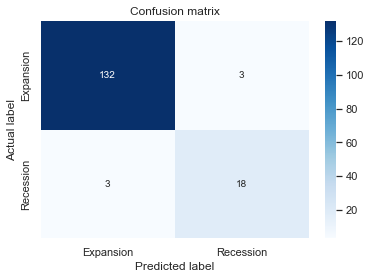

In [29]:
# create confustion matrix

CM = metrics.confusion_matrix(y_test_list, y_pred_list)
TN = CM[0][0]
FN = CM[1][0]
TP = CM[1][1]
FP = CM[0][1]

fig, ax=plt.subplots()
sns.heatmap(pd.DataFrame(metrics.confusion_matrix(y_test_list, y_pred_list)), annot=True, cmap="Blues" ,fmt='g')
plt.title('Confusion matrix'); plt.ylabel('Actual label'); plt.xlabel('Predicted label')
ax.xaxis.set_ticklabels(['Expansion', 'Recession']); ax.yaxis.set_ticklabels(['Expansion', 'Recession'])

Accuracy = metrics.accuracy_score(y_test_list, y_pred_list)*100
Recession_Precision = metrics.precision_score(y_test_list, y_pred_list)*100
Recession_Recall = metrics.recall_score(y_test_list, y_pred_list)*100
Recession_F1 = metrics.f1_score(y_test_list, y_pred_list)*100
Expansion_Precision = TN/(TN+FN)*100
Expansion_Recall = TN/(TN+FP)*100
Expansion_F1 = 2*(TN/(TN+FN))*(TN/(TN+FP))/((TN/(TN+FN)) +(TN/(TN+FP)))*100
ROC_AUC =  metrics.roc_auc_score(y_test_list, y_prob_list)
                                 
print("Overall Accuracy:", '%.3f' %Accuracy)                      
print("Recession: Precision:   ", '%.3f' % Recession_Precision)
print("Recession: Recall:      ", '%.3f' % Recession_Recall)
print("Recession: F1 score:    ", '%.3f' % Recession_F1)
print("Expansion: Precision: ", '%.3f' % Expansion_Precision)
print("Expansion: Recall:    ", '%.3f' % Expansion_Recall)
print("Expansion: F1 score:  ", '%.3f' % Expansion_F1)
print("ROC_AUC:         ", '%.3f' % ROC_AUC)

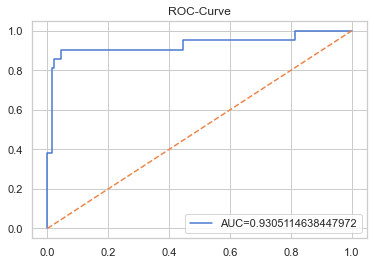

In [30]:
fpr, tpr, _=metrics.roc_curve(y_test_list, y_prob_list)
auc=metrics.roc_auc_score(y_test_list, y_prob_list)
plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.legend(loc=4)
plt.plot([0, 1], [0, 1], linestyle='--') # plot no skill
plt.title('ROC-Curve')
plt.show()

In [31]:
result = pd.DataFrame({'Recession_Actual': y[-n_forecast:], 'Recession_Predicted': y_pred_list, 'Recession_Probability': y_prob_list}, columns=['Recession_Actual', 'Recession_Predicted', 'Recession_Probability'])
#result.to_csv('recession_result_rfc.csv')
pd.options.display.max_rows=300
result

,Recession_Actual,Recession_Predicted,Recession_Probability
2008-01-01,1,1,0.786593
2008-02-01,1,1,0.985338
2008-03-01,1,0,0.128941
2008-04-01,1,1,0.935133
2008-05-01,1,1,0.938809
2008-06-01,1,1,0.590713
2008-07-01,1,1,0.982540
2008-08-01,1,1,0.985004
2008-09-01,1,1,0.943216
2008-10-01,1,1,0.975102


<AxesSubplot:>

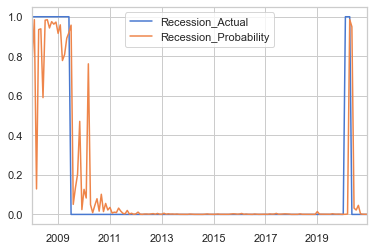

In [32]:
result['Recession_Actual'].plot(legend=True)
result['Recession_Probability'].plot(legend=True)

In [33]:
result.corr()

,Recession_Actual,Recession_Predicted,Recession_Probability
Recession_Actual,1.000000,0.834921,0.827701
Recession_Predicted,0.834921,1.000000,0.981904
Recession_Probability,0.827701,0.981904,1.000000


# Comparison of Model Results

In [34]:
model_results = pd.DataFrame([['Random Forest', 94.87, 80.95, 80.95, 80.95, 0.92],
                             ['Gradient Boosting', 95.51, 79.17, 90.48, 84.44, 0.91],
                             ['XGBoost', 96.15, 85.71, 85.71, 85.71, 0.93]],
                             columns = ['Model', 'Accuracy', 'Precision', 'Recall', 'F1 Score','ROC'])

model_results

,Model,Accuracy,Precision,Recall,F1 Score,ROC
0,Random Forest,94.87,80.95,80.95,80.95,0.92
1,Gradient Boosting,95.51,79.17,90.48,84.44,0.91
2,XGBoost,96.15,85.71,85.71,85.71,0.93


## Conclusion
### XGBoost outperforms both Random Forest and Gradinet Boosting Classifiers in terms of overall accuracy, precision, F1 score, and ROC.